https://institutefordiseasemodeling.github.io/Documentation/general/model-overview.html

Coursera: https://www.coursera.org/learn/epidemics

- $\beta =$ infectiousness of disease.

- $\gamma = 1/D$ where $D$ is the average duration of infection.


SI:
Once infected, stay infected forever. Infinite duration of infection, i.e. $\gamma = 0$, no healing. Like herpes.

SIS:
Once infected, can heal and become susceptible again. $\gamma > 0$. Like common cold.

SIR:
Immune after recovery, like chicken-pox.


- Death after certain time of fully having the disease, dict of runs with disease
- Different resistences per person, dict resistence, affects rate beta

In [1]:
import networkx as nx
import numpy as np
from random import sample

import matplotlib.pyplot as plt
plt.set_cmap('Reds')

### Random network generator

In [2]:
# The adjacency matrix (float full matrix)
def adj_mat(g):
    """Returns a dense adjacency matrix for a graph g"""
    return np.array(nx.adjacency_matrix(g).todense(), dtype=np.float64)

# randoms
from numpy.random import rand, choice

def random_adjmat(n, p=0.5):
    """Returns a graph where each edge appears with probability p"""
    X = rand(n, n)
    X[X < np.sqrt(1 - p)] = 0
    X[np.logical_or(X > 0, X.T > 0)] = 1
    np.fill_diagonal(X, 0)
    return X

def random_network(n, p=0.5):
    """Returns a networkx graph with n vertices where each edge 
    appears with probability p"""
    return nx.from_numpy_array(random_adjmat(n, p))

### Network plotter

In [3]:
"""
Draws the spin lattice with nodes coloured by spin and 
edge (i,j) labelled by Jij
"""
def draw_network(network, pos=None, title=None):
    # create colourmap from the spins
    cmap = [infection for node,infection in nx.get_node_attributes(network, 'infection').items()]

    # creating positions for drawing
    if type(pos) == tuple:
        n,m = pos
        pos = {node: (node//n,node%n) for node in network.nodes}
    
    nx.draw_networkx_nodes(network,pos,node_color=cmap,vmin=0,vmax=1,node_size=75)
    edgelist = [edge for edge in network.edges]
    nx.draw_networkx_edges(network, pos, edgelist,width=0.5)

    # if a title is supplied, add it to the plot
    if title:
        plt.title(title)
        
    plt.axis('off')

### Modelling

In [4]:
def update_node(old_infection,m,beta,duration,sus):
    
    new_node_infection = old_infection + sus*beta*m - 1/duration
        
    if new_node_infection < 0:
        new_node_infection = 0
    elif new_node_infection > 1:
        new_node_infection = 1
        
    return new_node_infection

In [5]:
def update_infections_no_death(network, beta:float, duration:float, sus_dict=None):
    
    infections = nx.get_node_attributes(network,'infection')
    new_infections = dict()
    
    for node in network.nodes:
        
        old_infection = infections[node]
        neighbors = network.neighbors(node)
        neighbor_infections = [infections[i] for i in neighbors]
        m = sum(neighbor_infections)
        
        # check if we have susceptibility or disease rounds records
        # if not, everyone is set as equally susceptible
        sus = sus_dict[node] if sus_dict else 1

        new_infections[node] = update_node(old_infection,m,beta,duration,sus)
        
    return new_infections

In [6]:
def run_sim(g,beta,duration,n_rounds,init_infect=1,sus_dict=None):
    
    pos = nx.spring_layout(g)
    n = len(g)
    
    # if only number to be infected is given, choose randoms to infect
    if type(init_infect) is int:
        init_infect_dict = {i:0 for i in range(n)}
        infect_indices = sample(range(n),init_infect)
        for i in infect_indices:
            init_infect_dict[i] = 1
        init_infect = init_infect_dict
    
    # set intial infections
    nx.set_node_attributes(g,init_infect,'infection')

    # initiate simulation
    draw_network(g,pos,'Initial')
    plt.show()

    for run in range(n_runs):

        new = update_infections_no_death(g,beta,duration)
        nx.set_node_attributes(g,new,'infection')
        draw_network(g,pos,'Run '+str(run+1))
        plt.show()

        if list(new.values()) == [0]*n:
            print('All recovered :)')
            break
        elif list(new.values()) == [1]*n:
            print('All infected :(')
            break

### Test

Types of graphs:  
https://networkx.github.io/documentation/networkx-1.10/reference/generators.html

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


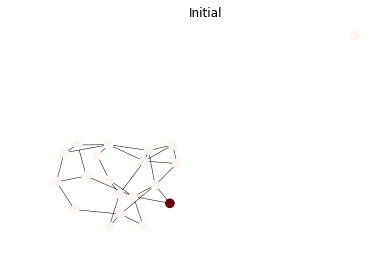

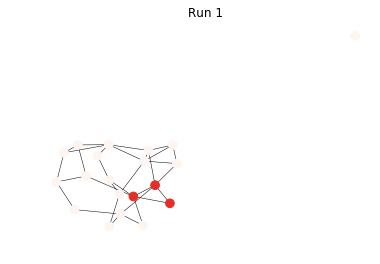

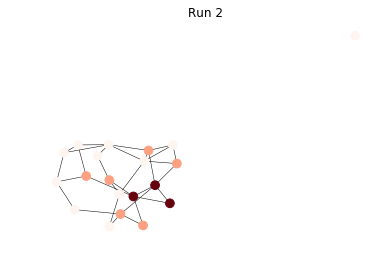

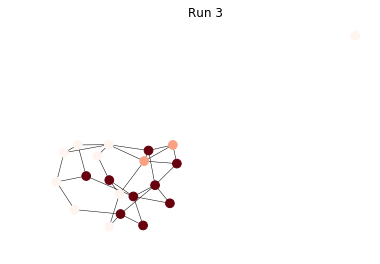

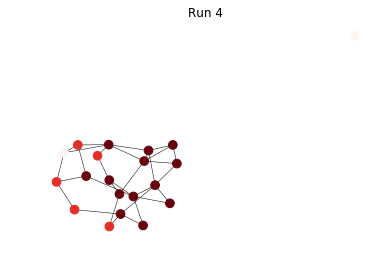

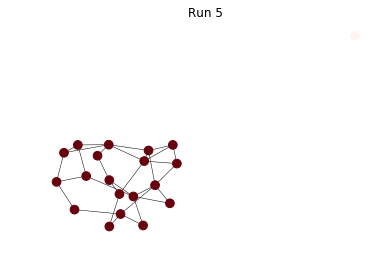

In [7]:
n = 20
g = random_network(n,0.15)
# #sus_dict = {i:(i+0.1)/n for i in range(n)}

# n = 10
# g = nx.complete_graph(n)

#g = nx.karate_club_graph()
#g = nx.balanced_tree(3,3)
#g = nx.relaxed_caveman_graph(3, 10,0.01)

# m, n = 5,5
# g0 = nx.grid_2d_graph(m, n)
# g = nx.convert_node_labels_to_integers(g0)

n_runs = 5
init_infect = 1

beta = 1
duration = 3
#duration = np.inf   # for SI, no recorvery

run_sim(g,beta,duration,n_runs,init_infect)